In [1]:
# imports
ROOT_DIR = "/home/bigboy/Krispin/projects/Metaworld"
%env MUJOCO_GL=egl

import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib
from dataclasses import dataclass

# scientific
import cv2
import numpy as np
import torch
import pytorch_lightning as pl

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils
import keyframes.pl_modules as pl_modules
import utils.predict_utils as keyframe_predict

import utils.slam_utils as slam_utils
import utils.depth_utils as depth_utils
import utils.match_utils as match_utils
import utils.transform_utils as transform_utils
import utils.inference_utils as inference_utils

import models.extern.mcc_model as mcc_model
import utils.mcc_misc_utils as mcc_misc_utils
import utils.mcc_data_utils as mcc_data_utils
import utils.predict_utils as predict_utils
import utils.vis_utils as vis_utils
import utils.plotly_utils as plotly_utils
from pytorch3d.io.obj_io import load_obj

import keyframes.grasp_pose as grasp_pose

import keyframes.policies.agent as agent
import keyframes.policies.pick_place_policy as pick_place_policy
import keyframes.policies.push_policy as push_policy

from metaworld.policies.policy import Policy
from metaworld.envs.mujoco.sawyer_xyz.sawyer_xyz_env import (
    SawyerXYZEnv,
)
import metaworld.policies.sawyer_assembly_v2_policy as sawyer_assembly_v2_policy

DEVICE = "cuda"


import models.extern.matchformer.lightning_loftr as lightning_loftr
import pytorch_lightning as pl
import argparse
from yacs.config import CfgNode as CN

from torchvision.transforms.functional import rgb_to_grayscale

import utils.torch_utils as torch_utils


env: MUJOCO_GL=egl


In [2]:
_CN = CN()

_CN.MATCHFORMER = CN()
_CN.MATCHFORMER.BACKBONE_TYPE = 'largela'# litela,largela,litesea,largesea
_CN.MATCHFORMER.SCENS = 'indoor' # indoor, outdoor
_CN.MATCHFORMER.RESOLUTION = (8,2)  #(8,2),(8,4)
_CN.MATCHFORMER.FINE_WINDOW_SIZE = 5
_CN.MATCHFORMER.FINE_CONCAT_COARSE_FEAT = True

_CN.MATCHFORMER.COARSE = CN()
_CN.MATCHFORMER.COARSE.D_MODEL = 256
_CN.MATCHFORMER.COARSE.D_FFN = 256

_CN.MATCHFORMER.MATCH_COARSE = CN()
_CN.MATCHFORMER.MATCH_COARSE.THR = 0.2
_CN.MATCHFORMER.MATCH_COARSE.BORDER_RM = 0
_CN.MATCHFORMER.MATCH_COARSE.MATCH_TYPE = 'dual_softmax'
_CN.MATCHFORMER.MATCH_COARSE.DSMAX_TEMPERATURE = 0.1
_CN.MATCHFORMER.MATCH_COARSE.SKH_ITERS = 3
_CN.MATCHFORMER.MATCH_COARSE.SKH_INIT_BIN_SCORE = 1.0
_CN.MATCHFORMER.MATCH_COARSE.SKH_PREFILTER = False
_CN.MATCHFORMER.MATCH_COARSE.TRAIN_COARSE_PERCENT = 0.2
_CN.MATCHFORMER.MATCH_COARSE.TRAIN_PAD_NUM_GT_MIN = 200
_CN.MATCHFORMER.MATCH_COARSE.SPARSE_SPVS = True

_CN.MATCHFORMER.FINE = CN()
_CN.MATCHFORMER.FINE.D_MODEL = 128
_CN.MATCHFORMER.FINE.D_FFN = 128

_CN.TRAINER = CN()
_CN.TRAINER.EPI_ERR_THR = 5e-4  # recommendation: 5e-4 for ScanNet, 1e-4 for MegaDepth (from SuperGlue)
_CN.TRAINER.POSE_GEO_MODEL = 'E'  # ['E', 'F', 'H']
_CN.TRAINER.POSE_ESTIMATION_METHOD = 'RANSAC'  # [RANSAC, DEGENSAC, MAGSAC]
_CN.TRAINER.RANSAC_PIXEL_THR = 0.5
_CN.TRAINER.RANSAC_CONF = 0.99999
_CN.TRAINER.RANSAC_MAX_ITERS = 10000
_CN.TRAINER.USE_MAGSACPP = False

# data sampler
_CN.TRAINER.DATA_SAMPLER = 'scene_balance'  # options: ['scene_balance', 'random', 'normal']
_CN.TRAINER.N_SAMPLES_PER_SUBSET = 200
_CN.TRAINER.SB_SUBSET_SAMPLE_REPLACEMENT = True  # whether sample each scene with replacement or not
_CN.TRAINER.SB_SUBSET_SHUFFLE = True  # after sampling from scenes, whether shuffle within the epoch or not
_CN.TRAINER.SB_REPEAT = 1  # repeat N times for training the sampled data
_CN.TRAINER.SEED = 66

def get_cfg_defaults():
    """Get a yacs CfgNode object with default values for my_project."""
    # Return a clone so that the defaults will not be altered
    # This is for the "local variable" use pattern
    return _CN.clone()

In [3]:
def parse_args():
    # init a costum parser which will be added into pl.Trainer parser
    # check documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html#trainer-flags
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument(
        'data_cfg_path', type=str, help='data config path')
    parser.add_argument(
        '--ckpt_path', type=str, default="weights/indoor_ds.ckpt", help='path to the checkpoint')
    parser.add_argument(
        '--dump_dir', type=str, default=None, help="if set, the matching results will be dump to dump_dir")
    parser.add_argument(
        '--profiler_name', type=str, default='inference', help='options: [inference, pytorch], or leave it unset')
    parser.add_argument(
        '--batch_size', type=int, default=1, help='batch_size per gpu')
    parser.add_argument(
        '--num_workers', type=int, default=2)
    parser.add_argument(
        '--thr', type=float, default=None, help='modify the coarse-level matching threshold.')

    parser = pl.Trainer.add_argparse_args(parser)
    return parser.parse_args()

In [4]:
# params

batch_size = 8
num_workers = 2
profiler_name = "inference"  # options: [inference, pytorch], or leave it unset

thr = None  # coarse-level matching threshold
ckpt_path = "/home/bigboy/Krispin/projects/MatchFormer/model/weights/indoor-large-SEA.ckpt"
dump_dir = None  # matching results will be dump to dump_dir

backbone_type = 'largesea'# litela,largela,litesea,largesea
scens = 'indoor' # indoor, outdoor

# data_cfg_path = ""

In [5]:
# init model


# parse arguments
# args = parse_args()
# init default-cfg and merge it with the main- and data-cfg
config = get_cfg_defaults()
# config.merge_from_file(args.data_cfg_path)
pl.seed_everything(config.TRAINER.SEED)  # reproducibility

config.MATCHFORMER.BACKBONE_TYPE = backbone_type
config.MATCHFORMER.SCENS = scens

# tune when testing
if thr is not None:
    config.LOFTR.MATCH_COARSE.THR = thr

# lightning module
model = lightning_loftr.PL_LoFTR(
    config, 
    pretrained_ckpt=ckpt_path,
    dump_dir=dump_dir
)


Global seed set to 66
2023-12-30 18:21:17.543 | INFO     | models.extern.matchformer.lightning_loftr:__init__:34 - Load '/home/bigboy/Krispin/projects/MatchFormer/model/weights/indoor-large-SEA.ckpt' as pretrained checkpoint


## Inference

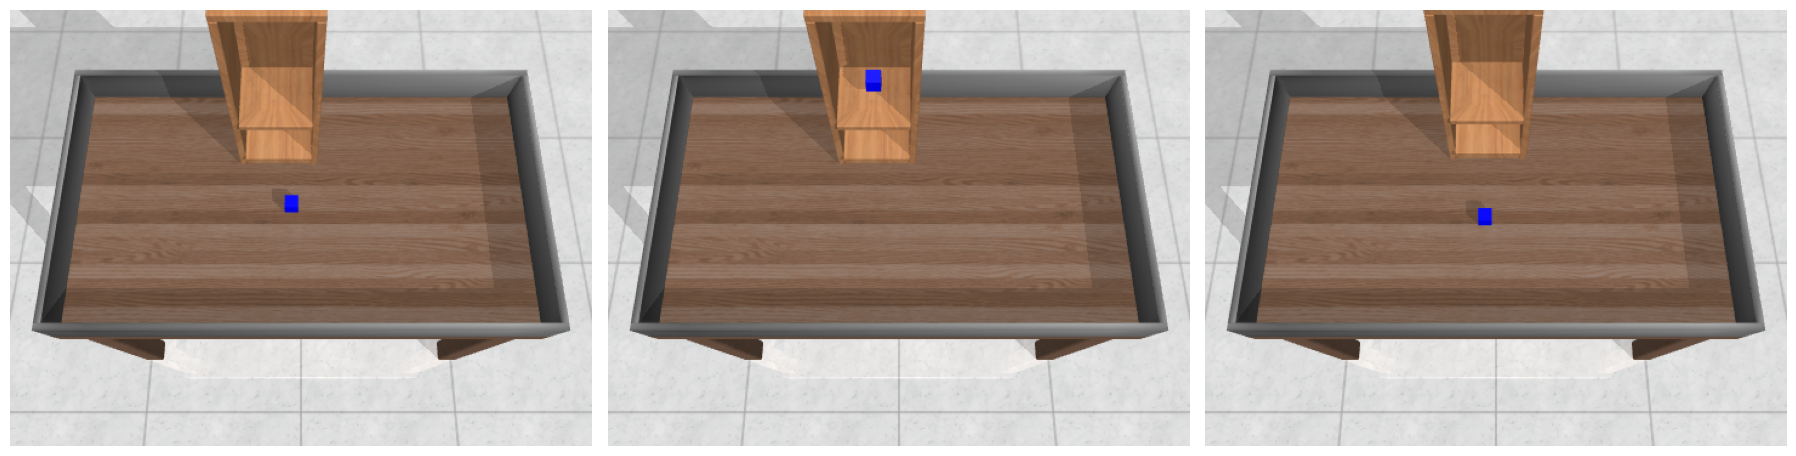

In [6]:
# generate test data
# param
env_index = 45
img_height, img_width = 360, 480

# generate env and renderer
env, expert_policy, renderer = env_utils.generate_env_and_renderer(env_index, height=img_height, width=img_width, camera_name="keyframes")
T_world2pixel = cu.get_camera_transform_matrix(env, "keyframes", img_height, img_width)
T_pixel2world = np.linalg.inv(T_world2pixel)


# generate keyframes
keyframe_data = keyframe_utils.generate_keyframes(env, renderer)

img_ref_0 = keyframe_data["img"][0]
img_ref_1 = keyframe_data["img"][1]
depth_ref_0 = keyframe_data["depth"][0]
depth_ref_1 = keyframe_data["depth"][1]

# generate keyframe of current env
img_cur, depth_cur = keyframe_utils.generate_cur_keyframe(env, renderer)

viz2d.plot_images([img_ref_0, img_ref_1, img_cur])

In [7]:
img1 = cv2.imread("/home/bigboy/Krispin/projects/osil/projects/blocks_slam/test_imgs/img1.png")
img2 = cv2.imread("/home/bigboy/Krispin/projects/osil/projects/blocks_slam/test_imgs/img2.png")

img_l = cv2.imread("/home/bigboy/Krispin/projects/Metaworld/keyframes/test_data/ftm_left.jpg")
img_r = cv2.imread("/home/bigboy/Krispin/projects/Metaworld/keyframes/test_data/ftm_right.jpg")



In [8]:
b = 2

def create_test_data(img_0, img_1):
    b = 2
    img_0 = torch.from_numpy(img_0).permute(2, 0, 1).unsqueeze(0).repeat(b, 1, 1, 1).float()
    img_1 = torch.from_numpy(img_1).permute(2, 0, 1).unsqueeze(0).repeat(b, 1, 1, 1).float()
    img_0 = rgb_to_grayscale(img_0)
    img_1 = rgb_to_grayscale(img_1)
    # depth_0 = torch.from_numpy(depth_0).unsqueeze(0).repeat(b, 1, 1).float()
    # depth_1 = torch.from_numpy(depth_1).unsqueeze(0).repeat(b, 1, 1).float()
    matchformer_input_data = {
        "image0": img_0 / 255,  # (1, h, w)
        "image1": img_1 / 255,
        # "depth0": depth_0,  # (h, w)
        # "depth1": depth_1,
        # 'mask0' : mask0,
        # 'mask1' : mask1,
        # "T_0to1": torch.eye(4).repeat(b, 1, 1),  # (4, 4)
        # "T_1to0": torch.eye(4).repeat(b, 1, 1),
        # "K0": torch.eye(3).repeat(b, 1, 1),  # (3, 3)
        # "K1": torch.eye(3).repeat(b, 1, 1),
        # "dataset_name": "ScanNet",
        # "scene_id": torch.tensor([0]).repeat(b, 1),
        # "pair_id": torch.tensor([0]).repeat(b, 1),
        # "pair_names": [
        #     ("a", "b"),
        #     ("c", "d"),
        # ]  # (osp.join(scene_name, 'color', f'{stem_name_0}.jpg'),
        # osp.join(scene_name, 'color', f'{stem_name_1}.jpg'))
    }
    return matchformer_input_data

In [9]:
model.to("cuda:1")
model.eval()
model.training

False

In [10]:
model.matcher.coarse_matching.thr

0.2

In [11]:
test_data = create_test_data(img1, img2)
test_data = torch_utils.to_torch(test_data, device="cuda:1") # to cuda

In [12]:
test_data["image1"].device

device(type='cuda', index=1)

In [13]:
with torch.no_grad():
    model.matcher(test_data)

In [14]:
test_data.keys()

dict_keys(['image0', 'image1', 'bs', 'hw0_i', 'hw1_i', 'hw0_c', 'hw1_c', 'hw0_f', 'hw1_f', 'conf_matrix', 'b_ids', 'i_ids', 'j_ids', 'gt_mask', 'm_bids', 'mkpts0_c', 'mkpts1_c', 'mconf', 'W', 'expec_f', 'mkpts0_f', 'mkpts1_f'])

In [15]:
test_data["mkpts0_f"].shape

torch.Size([5444, 2])

In [16]:
test_data["mkpts1_f"].shape

torch.Size([5444, 2])

In [17]:
b_ids = torch_utils.to_numpy(test_data["b_ids"])
mkpts0_f = torch_utils.to_numpy(test_data["mkpts0_f"])[b_ids==0,:]
mkpts1_f = torch_utils.to_numpy(test_data["mkpts1_f"])[b_ids==0,:]
conf_matrix = torch_utils.to_numpy(test_data["conf_matrix"])

# matches0 = np.argmax(conf_matrix[0,:mkpts0_f.shape[0],:-5], axis=-1)
# kpts0 = mkpts0_f.copy()
# kpts1 = mkpts1_f[matches0]

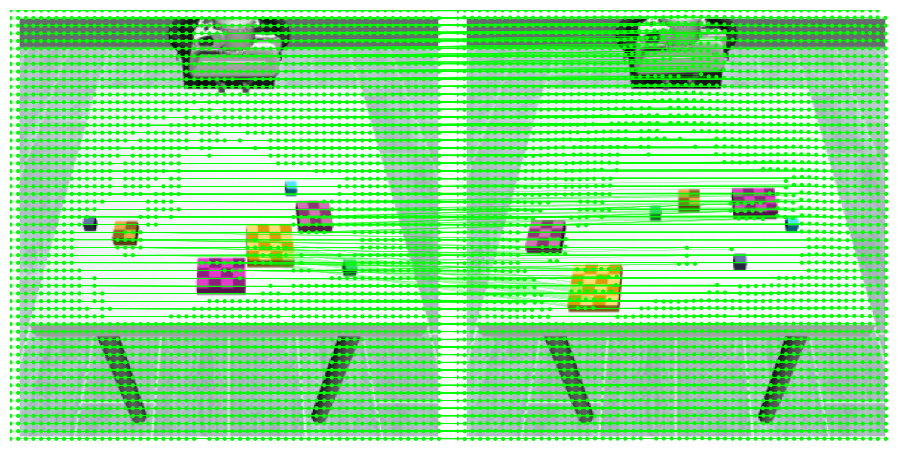

In [19]:
inference_utils.show_matches_kpts(
    img1, 
    img2,
    mkpts0_f, 
    mkpts1_f
)

In [16]:
config.MATCHFORMER

CfgNode({'BACKBONE_TYPE': 'largela', 'SCENS': 'indoor', 'RESOLUTION': (8, 2), 'FINE_WINDOW_SIZE': 5, 'FINE_CONCAT_COARSE_FEAT': True, 'COARSE': CfgNode({'D_MODEL': 256, 'D_FFN': 256}), 'MATCH_COARSE': CfgNode({'THR': 0.2, 'BORDER_RM': 0, 'MATCH_TYPE': 'dual_softmax', 'DSMAX_TEMPERATURE': 0.1, 'SKH_ITERS': 3, 'SKH_INIT_BIN_SCORE': 1.0, 'SKH_PREFILTER': False, 'TRAIN_COARSE_PERCENT': 0.2, 'TRAIN_PAD_NUM_GT_MIN': 200, 'SPARSE_SPVS': True}), 'FINE': CfgNode({'D_MODEL': 128, 'D_FFN': 128})})